In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.graph_objs import Figure, Histogram, Layout

In [3]:
pd.set_option('display.max_columns', 50)

In [583]:
countries = ['US', 'DE', 'CA', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
dframes = [code.lower()+'_df' for code in countries]

cat_ids = pd.read_csv('yt category list.csv', delimiter=' - ', engine='python')
for code, df in zip(countries, dframes):
    globals()[df] = pd.read_csv(f'{code}videos.csv', parse_dates=['trending_date', 'publish_time'], \
                                encoding_errors='ignore').merge(cat_ids, on='category_id', how='inner')\
                                .drop(['category_id', 'thumbnail_link'], axis=1)

In [584]:
# we now have a dataframe for each of the countries
# but we want to start by analyzing only one dataframe first
# lets start with the US

df = us_df
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs


In [585]:
# lets first remove some bias
# this will be videos with comments or ratings disabled
# this will also be videos with errors or has been removed

df = df[~(df['comments_disabled'] | \
                df['ratings_disabled'] | \
                df['video_error_or_removed']) == True]

df = df.drop(['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], axis=1)
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs


In [586]:
# trending date is of type object, which is not valuable to us.
# lets make that a datetime object, then aggregate to find how long a video will take to trend

df['trending_date'] = pd.to_datetime(us_df['trending_date'], format='%y.%d.%m')
df['trending_delta'] = df['trending_date'] - df['publish_time'].dt.tz_localize(None)
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57


In [630]:
# lets also aggregate certain columns for better analysis

df['like_pct'] = 100 * round(df['likes'] / (df['likes'] + df['dislikes']), 2) # ratio of likes to dislikes
df['len_title'] = df['title'].str.findall(r'[.]*').str.len() # count chars in title
df['len_desc'] = df['description'].str.findall(r'[.]*').str.len() # count chars in desc
df['pct_cap'] = 100 * round(df['title'].str.findall(r'[A-Z]').str.len() /
                df['title'].str.findall(r'[A-Za-z]').str.len(), 2) # ratio of cap letters in title
df['qty_tags'] = np.where(df['tags'] == '[none]', 0, df['tags'].str.split('|').str.len()) # count number of tags

df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59,95.0,35,1411.0,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28,93.0,21,103.0,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57,72.0,76,631.0,79.0,44


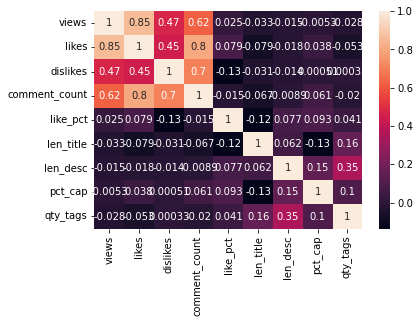

In [588]:
# lets create a correlation matrix with the base data and see what we get
sns.heatmap(df.corr(), annot=True)
plt.show()

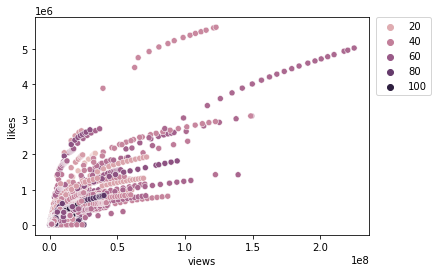

In [589]:
# as expected, we see a strong positive correlations between views and likes
sns.scatterplot(x='views', y='likes', data=df, hue='len_title')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

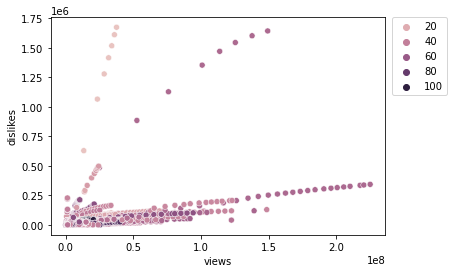

In [590]:
# the correlation for views and dislikes is also positive, but a little weaker
sns.scatterplot(x='views', y='dislikes', data=df, hue='len_title')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

based on these two datapoints, it seems that videos that trend due to 'dislikes' are more likely to be interacted with in the earlier stages of the trending views

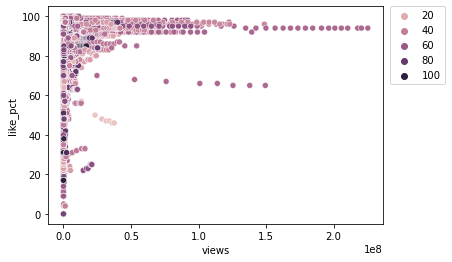

In [591]:
# additionally, it may be helpful to look a bit closer at the like-dislike ratio
sns.scatterplot(x='views', y='like_pct', data=df, hue='len_title')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Entertainment'),
  Text(1, 0, 'Music'),
  Text(2, 0, 'Howto & Style'),
  Text(3, 0, 'Comedy'),
  Text(4, 0, 'People & Blogs'),
  Text(5, 0, 'News & Politics'),
  Text(6, 0, 'Science & Technology'),
  Text(7, 0, ' Film & Animation'),
  Text(8, 0, 'Sports'),
  Text(9, 0, 'Education'),
  Text(10, 0, 'Pets & Animals'),
  Text(11, 0, 'Gaming'),
  Text(12, 0, 'Travel & Events'),
  Text(13, 0, 'Autos & Vehicles'),
  Text(14, 0, 'Shows'),
  Text(15, 0, 'Nonprofits & Activism')])

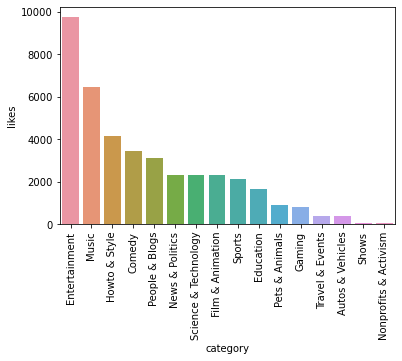

In [592]:
# grouping trending videos by category
df2 = df.groupby('category').count().reset_index().sort_values('likes', ascending=False)
sns.barplot(x='category', y='likes', data=df2)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Music'),
  Text(1, 0, 'Gaming'),
  Text(2, 0, 'Comedy'),
  Text(3, 0, ' Film & Animation'),
  Text(4, 0, 'Howto & Style'),
  Text(5, 0, 'Shows'),
  Text(6, 0, 'People & Blogs'),
  Text(7, 0, 'Entertainment'),
  Text(8, 0, 'Science & Technology'),
  Text(9, 0, 'Pets & Animals'),
  Text(10, 0, 'Education'),
  Text(11, 0, 'Travel & Events'),
  Text(12, 0, 'Autos & Vehicles'),
  Text(13, 0, 'Sports'),
  Text(14, 0, 'Nonprofits & Activism'),
  Text(15, 0, 'News & Politics')])

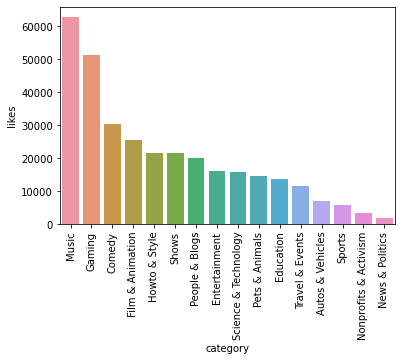

In [635]:
# and taking their median, since it's skewed to the left (median > mean)
df2 = df.groupby('category').median().reset_index().sort_values('likes', ascending=False)
sns.barplot(x='category', y='likes', data=df2)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='len_title', ylabel='Count'>

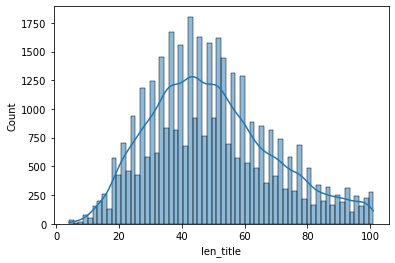

In [594]:
# we can also see that in 
sns.histplot(x='len_title', data=df, kde=True)
# sns.kdeplot(df['len_title'], shade=True)

In [595]:
df.loc[[24]].tags

24    [none]
Name: tags, dtype: object

<AxesSubplot:xlabel='pct_cap', ylabel='like_pct'>

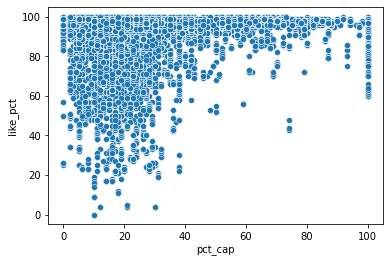

In [597]:
sns.scatterplot(x='pct_cap', y='like_pct', data=df)

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_25012/3278285594.py:1: FutureWarning: ['video_id', 'trending_date', 'title', 'channel_title', 'publish_time', 'tags', 'description', 'trending_delta'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  b = df.groupby('category').agg(['mean', 'std', 'sum', 'median'])


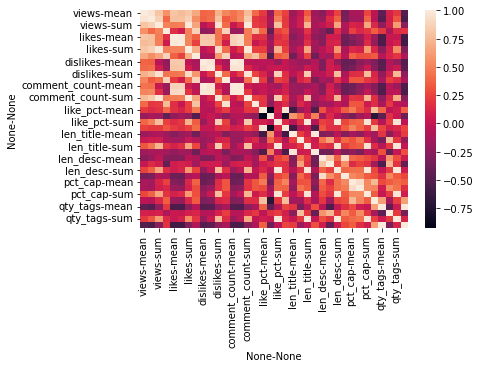

In [599]:
b = df.groupby('category').agg(['mean', 'std', 'sum', 'median'])
sns.heatmap(b.corr())
plt.show()

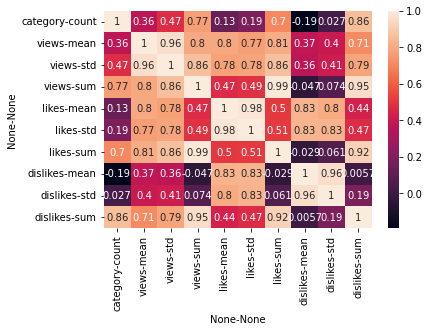

In [600]:
a = df.groupby('category').agg({'category':['count'], \
                            'views': ['mean', 'std', 'sum'], \
                            'likes': ['mean', 'std', 'sum'], \
                            'dislikes': ['mean', 'std', 'sum']})

sns.heatmap(a.corr(), annot=True)
plt.show()

In [601]:
# lets first see how much of each category there is

df.groupby('category').agg(count=('category', 'count'),
                           views=('views', 'mean'), 
                           likes=('like_pct', 'mean')
                          ).sort_values(by='count', ascending=False)

,count,views,likes
category,,,
Entertainment,9749,2.062894e+06,92.385270
Music,6447,6.213627e+06,96.396463
Howto & Style,4135,9.839684e+05,96.274970
Comedy,3455,1.481164e+06,95.509407
People & Blogs,3130,1.409027e+06,94.018856
News & Politics,2313,5.406228e+05,78.947255
Science & Technology,2310,1.390258e+06,94.390476
Film & Animation,2301,3.141956e+06,93.736636
Sports,2140,2.037210e+06,91.021028


<AxesSubplot:xlabel='like_pct', ylabel='Count'>

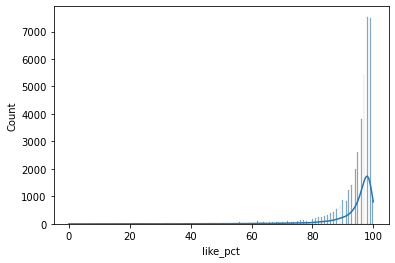

In [602]:
sns.histplot(x='like_pct', data=df, kde=True)

<AxesSubplot:xlabel='len_desc', ylabel='qty_tags'>

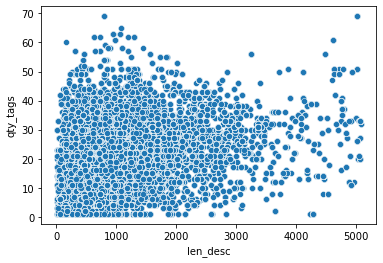

In [603]:
sns.scatterplot(x='len_desc', y='qty_tags', data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Howto & Style'),
  Text(1, 0, 'Gaming'),
  Text(2, 0, 'People & Blogs'),
  Text(3, 0, 'Pets & Animals'),
  Text(4, 0, 'Comedy'),
  Text(5, 0, 'Entertainment'),
  Text(6, 0, 'Travel & Events'),
  Text(7, 0, 'Music'),
  Text(8, 0, 'Sports'),
  Text(9, 0, 'Autos & Vehicles'),
  Text(10, 0, 'Science & Technology'),
  Text(11, 0, 'Shows'),
  Text(12, 0, ' Film & Animation'),
  Text(13, 0, 'Education'),
  Text(14, 0, 'News & Politics'),
  Text(15, 0, 'Nonprofits & Activism')])

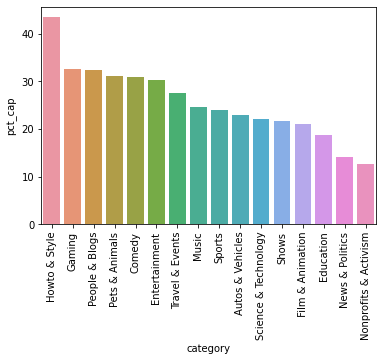

In [604]:
df3 = df.groupby('category').mean().reset_index().sort_values('pct_cap', ascending=False)
sns.barplot(x='category', y='pct_cap', data=df3)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='len_title', ylabel='like_pct'>

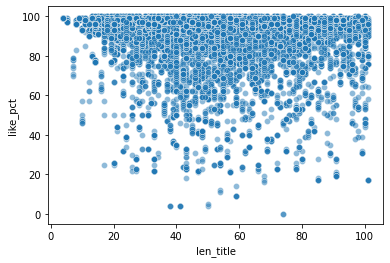

In [605]:
sns.scatterplot(x='len_title', y='like_pct', data=df, alpha=0.5)

<AxesSubplot:xlabel='len_desc', ylabel='Count'>

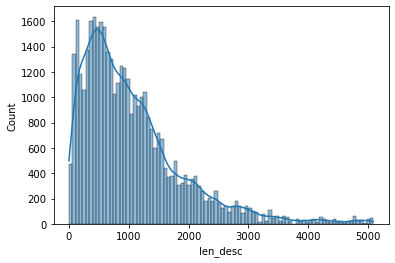

In [606]:
# the length of the description tends to skew to the left
# this may not necessarily mean that videos that write more tend to fail less
# it's of
sns.histplot(x='len_desc', data=df, kde=True)

<AxesSubplot:xlabel='trending_delta'>

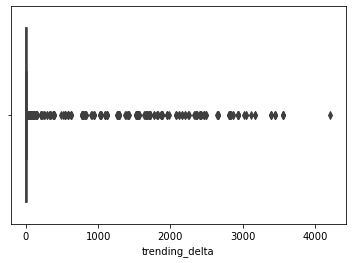

In [607]:
sns.boxplot(x=df['trending_delta'].dt.days, data=df)

<AxesSubplot:xlabel='qty_tags'>

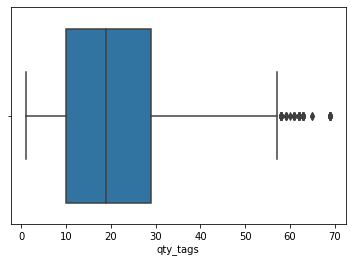

In [608]:
sns.boxplot(x='qty_tags', data=df)

In [609]:
df['publish_time'].dt.day

0        13
1        21
2        11
3        11
4        11
         ..
40944    10
40945    10
40946    10
40947    10
40948    10
Name: publish_time, Length: 40230, dtype: int64

min: 11         max: 6


/Users/setone/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trending_date', ylabel='Density'>

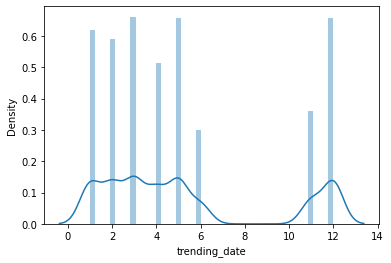

In [610]:
# lets take a look at the trending data
print(f"min: {df['trending_date'].dt.date.min().month} \
        max: {df['trending_date'].dt.date.max().month}")

# we unfortunately don't have a full complete year of trending data to analyze
sns.distplot(df['trending_date'].dt.month, )
# it would be extremely interesting to see, but it looks like more videos trend during the holidays
# and trends the least during the summer, which makes sense
# hopefully other countries have the data to fill in the gap

<AxesSubplot:xlabel='publish_time', ylabel='Count'>

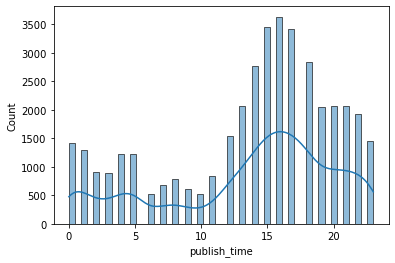

In [611]:
# but based on what we have, we can at least take the statistics to see active user counts
# it looks like videos are likely to trend around noon, with the highest peak ~4pm
# this makes sense as people are checking off work
sns.histplot(df['publish_time'].dt.hour, kde=True)

In [612]:
df.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,description,category,trending_delta,like_pct,len_title,len_desc,pct_cap,qty_tags
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,0 days 06:46:59,95.0,35,1411.0,100.0,1
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,Kittens come out of the eggs in a Thai commerc...,People & Blogs,206 days 17:12:28,93.0,21,103.0,24.0,4
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,2 days 08:59:57,72.0,76,631.0,79.0,44


<AxesSubplot:xlabel='trending_delta'>

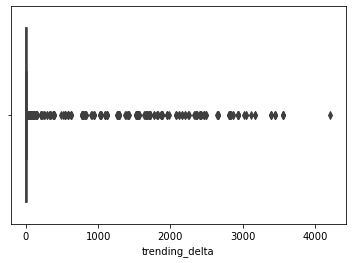

In [613]:
sns.boxplot(x=df['trending_delta'].dt.days, data=df)

In [619]:
df4 = df.copy()
df4['trending_delta'] = df4['trending_delta'].dt.days
df4 = df4.groupby('category').mean().sort_values('trending_delta', ascending=False).reset_index()
df4.head(3)

,category,views,likes,dislikes,comment_count,trending_delta,like_pct,len_title,len_desc,pct_cap,qty_tags
0,Autos & Vehicles,1.398908e+06,11505.349593,658.373984,2104.482385,43.758808,90.967480,51.070461,793.123626,22.910569,16.195122
1,Film & Animation,3.141956e+06,71692.945241,2591.907432,7756.439809,39.505432,93.736636,48.389831,1057.118902,20.958714,18.742721
2,Education,7.179818e+05,29961.548662,822.326034,3310.292579,35.642336,95.948297,43.937956,1507.070423,18.822441,21.745134


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Autos & Vehicles'),
  Text(1, 0, ' Film & Animation'),
  Text(2, 0, 'Education'),
  Text(3, 0, 'Sports'),
  Text(4, 0, 'Gaming'),
  Text(5, 0, 'News & Politics'),
  Text(6, 0, 'Science & Technology'),
  Text(7, 0, 'People & Blogs'),
  Text(8, 0, 'Music'),
  Text(9, 0, 'Entertainment'),
  Text(10, 0, 'Shows'),
  Text(11, 0, 'Comedy'),
  Text(12, 0, 'Howto & Style'),
  Text(13, 0, 'Pets & Animals'),
  Text(14, 0, 'Travel & Events'),
  Text(15, 0, 'Nonprofits & Activism')])

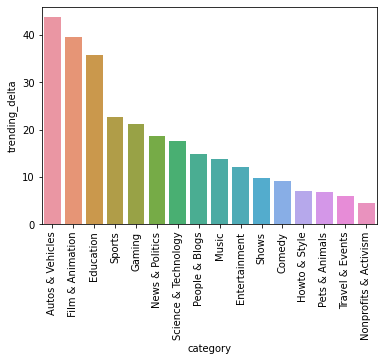

In [620]:
sns.barplot(x='category', y='trending_delta', data=df4)
plt.xticks(rotation=90)

TypeError: 'str' object is not callable

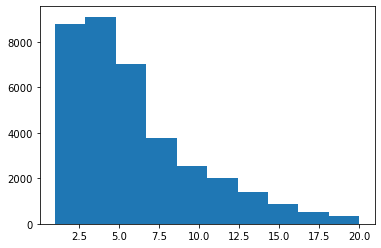

In [621]:
plt.hist(df['trending_delta'].dt.days, range=(1, 20))
plt.xlabel('# of days before viral')
plt.ylabel('videos')
plt.title('')

/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_25012/2842660229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))
/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_25012/2842660229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))
/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_25012/2842660229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))
/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T/ipykernel_25012/2842660229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))
/var/folders/qp/1k1ym6rd1z34yt05vjspksl40000gn/T

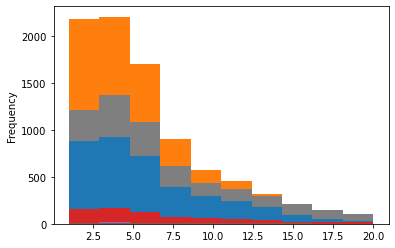

In [623]:
for c in list(df['category'].unique()):
    df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))